# TinyVGG for Fasnion MNIST dataset

In [1]:
import torch, torchvision
from torch import nn
import matplotlib.pyplot as plt
%matplotlib inline

### Get the data

We can get the data from `torchvision.datasets.FashionMNIST`. This way we can avoid crawling the web for datasets, which is annoying.

In [2]:
transform_simple = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(64, 64)),
    torchvision.transforms.ToTensor()
])

train_dataset = torchvision.datasets.FashionMNIST(
    root=".datasets",
    train=True,
    transform=transform_simple,
    target_transform=None,
    download=True
)

test_dataset = torchvision.datasets.FashionMNIST(
    root=".datasets",
    train=False,
    transform=transform_simple,
    target_transform=None,
    download=True
)

Then we turn them into Python iterables for training and testing.

In [3]:
import torch.utils.data

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=True
)

test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=32,
    shuffle=False
)

In [4]:
len(train_dataloader), len(test_dataloader)

(1875, 313)

### Building the model

Using the TinyVGG convolutional neural network architecture as a reference, we can build this simple neural network to classify our different types of clothing.

In [5]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self, in_shape, hidden_units, out_shape):
        super().__init__()
        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_shape, out_channels=hidden_units, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3)
        )
        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*5*5, out_features=out_shape)
        )
    
    def forward(self, X):
        return self.classifier.forward(
            self.conv_layer_2.forward(
                self.conv_layer_1.forward(X)
            )
        )

In [6]:
model = FashionMNISTModelV0(
    in_shape=1,
    hidden_units=40,
    out_shape=len(train_dataset.classes)
)

### Train the model

We can use cross-entropy loss as our loss function, which is often used with multi-class classification. For the optimizer we can use Adam, which is pretty good, gets the job done.

It's ok to train it for 3 epochs because we iterate over the whole dataset each epoch. So really it is `1857 * 30 * 3` epochs, which is roughly 167,130 forward passes just for training.

In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0005)

In [8]:
epochs = 3

for epoch in range(epochs):
    for batch, (X, y) in enumerate(train_dataloader):
        model.train()
        y_logits = model.forward(X)
        loss = loss_fn(y_logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"Batch: {batch} | Loss: {loss}", end="\r")

    loss = 0
    for batch, (X, y) in enumerate(test_dataloader):
        model.eval()
        with torch.inference_mode():
            y_logits = model.forward(X)
            loss += loss_fn(y_logits, y).item()
        print(f"Batch: {batch} | Loss: {loss / (batch+1)}", end="\r")
    loss = loss / (batch+1)
    
    print(f"Epoch: {epoch} | Loss: {loss}")

Epoch: 0 | Loss: 0.39437568359100783835
Epoch: 1 | Loss: 0.31804495946334575766
Epoch: 2 | Loss: 0.328607258324425060644


### Evaluate the model

Now we can check how good our model really learned our data. First we can calculate the accuracy.

In [9]:
y_preds = []
y_true = []

for batch, (X,  y) in enumerate(test_dataloader):
    model.eval()
    with torch.inference_mode():
        y_logits = model.forward(X)
        y_pred = y_logits.argmax(dim=1)
        y_preds = y_preds + y_pred.tolist()
        y_true = y_true + y.tolist()

In [10]:
from torchmetrics import Accuracy

accuracy = Accuracy(task="multiclass", num_classes=len(train_dataset.classes))
accuracy = accuracy(torch.Tensor(y_preds), torch.Tensor(y_true))

print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 88.43%


### Graphs and visuals

We already got all test predictions, now we can make some graphs.

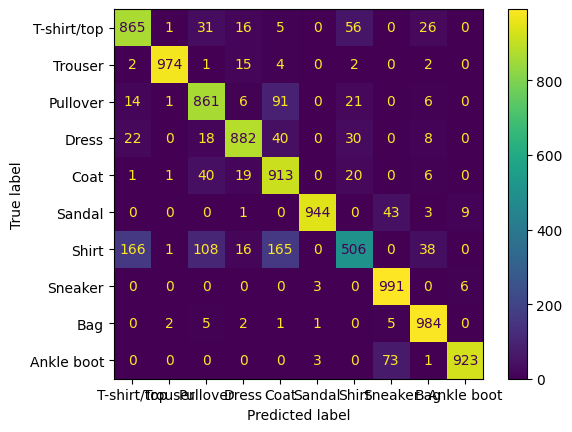

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

confmat = confusion_matrix(y_true, y_preds)
# Labels kinda overlap lol
ConfusionMatrixDisplay(confmat, display_labels=test_dataset.classes).plot()

Sample from the dataset

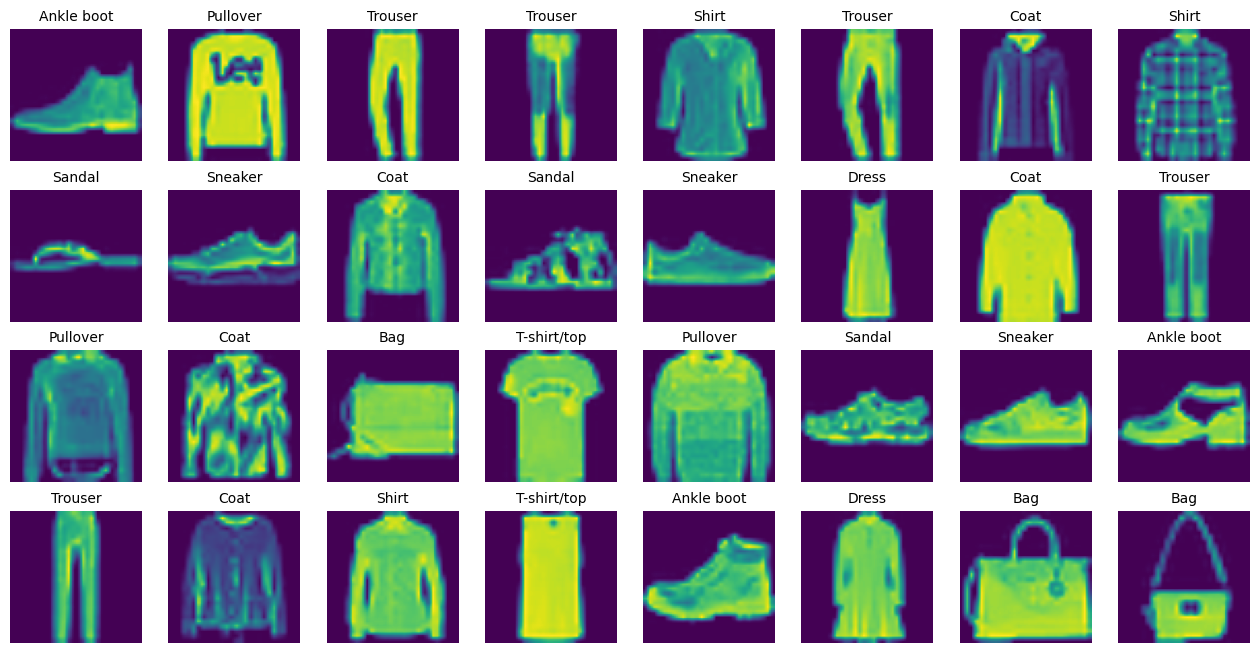

In [12]:
data_batch_sample, label_batch_sample = next(iter(test_dataloader))

plt.figure(figsize=(16, 8))
for index, (image, label) in enumerate(zip(data_batch_sample, label_batch_sample)):
    plt.subplot(4, 8, index+1)
    plt.title(test_dataset.classes[label.item()], fontsize=10)
    plt.imshow(image.reshape(64, 64, 1))
    plt.axis(False)